In [1]:
import sys

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import plot_sim as ps

#%matplotlib notebook
#DEFAULT_FIGSIZE = (8, 6)
%matplotlib inline 
DEFAULT_FIGSIZE = (12, 8)

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

In [2]:
def plot_torques(log):
    commanded_torque = ps.get_kollmorgen_command_torque(
        log.records.actuators.kollmorgen_command_velocity)
    measured_torque = ps.get_kollmorgen_applied_torque(
        log.records.sensors.kollmorgen_actual_torque)
    measured_sensor_torque = ps.get_kistler_sensor_torque(
        log.records.sensors.kistler_measured_torque)
    
    encoder_angle = log.records.sensors.steer_encoder_count * 2*np.pi/152000
    encoder_angle[np.where(encoder_angle > np.pi)[0]] -= 2*np.pi
    
    encoder_rate = scipy.signal.savgol_filter(
        encoder_angle, 101, 2, 1, 0.001)

    plt.close('all')
    fig, ax = plt.subplots()
    ax.plot(log.t, commanded_torque,
            label='commanded motor torque')
    
    ax.plot(log.t,
            measured_torque,
            label='measured motor torque')
    
    ax.plot(log.t,
            measured_sensor_torque,
            label='measured sensor torque')
    
    ax.plot(log.t,
            encoder_angle - encoder_angle[0],
            label='measured steer angle')
    
    ax.plot(log.t,
            encoder_rate,
            label='estimated steer rate')
    ax.legend()
    ax.set_xlabel('time [s]')
    ax.set_ylabel('[N-m, rad]')
    return fig, ax

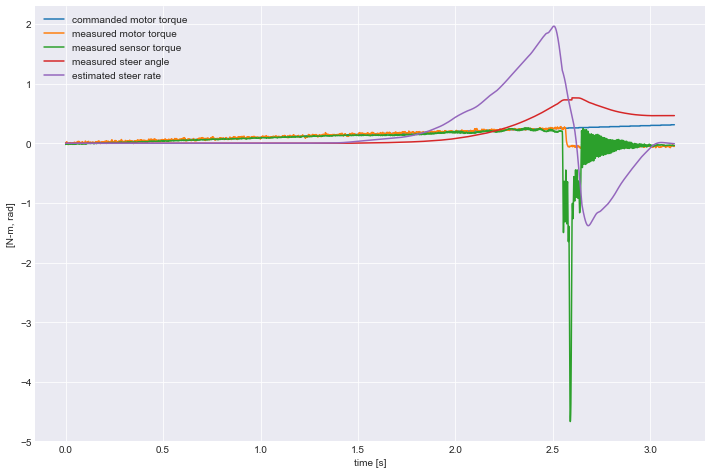

In [3]:
log = ps.ProcessedRecord('logs/positive_friction.pb.cobs')
plt.close('all')
plot_torques(log)
plt.show()

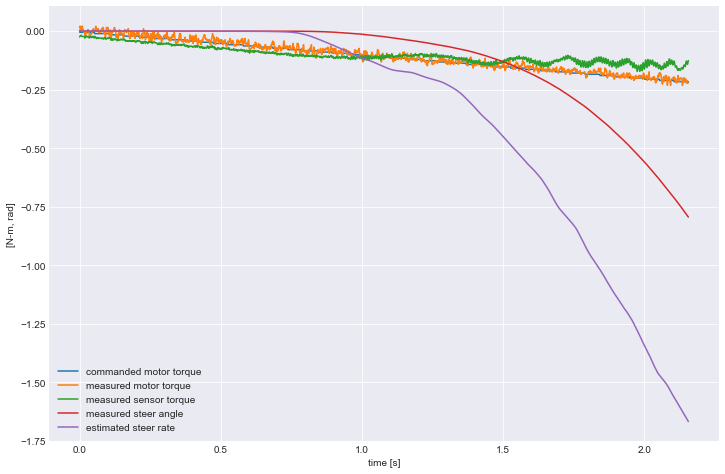

In [4]:
log = ps.ProcessedRecord('logs/negative_friction.pb.cobs')
plt.close('all')
plot_torques(log)
plt.show()

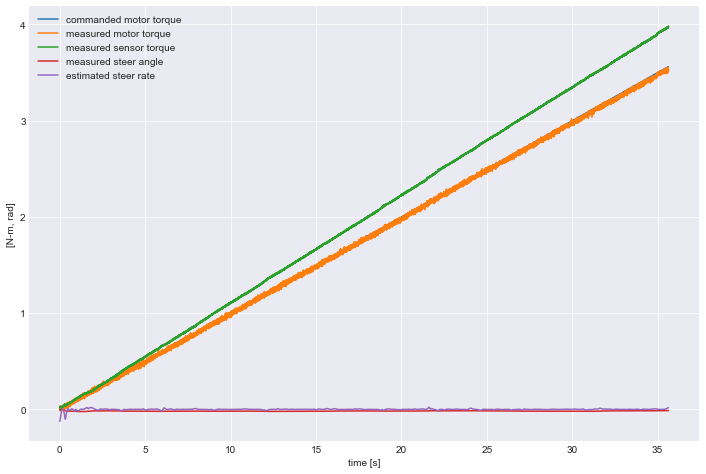

In [5]:
log = ps.ProcessedRecord('logs/positive_ramp.pb.cobs')
plt.close('all')
plot_torques(log)
plt.show()

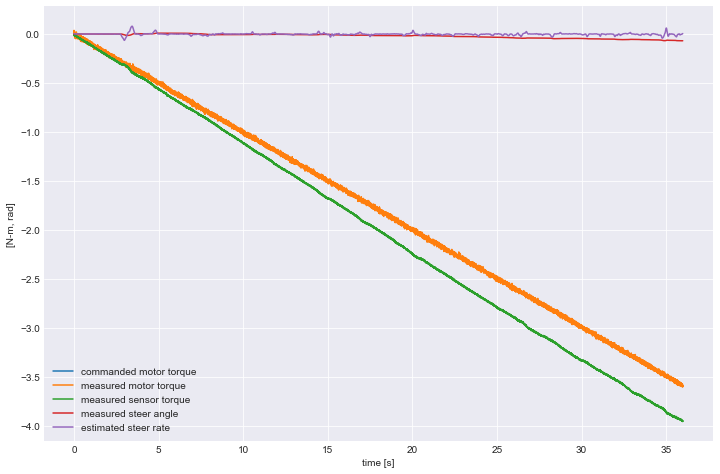

In [6]:
log = ps.ProcessedRecord('logs/negative_ramp.pb.cobs')
plt.close('all')
plot_torques(log)
plt.show()

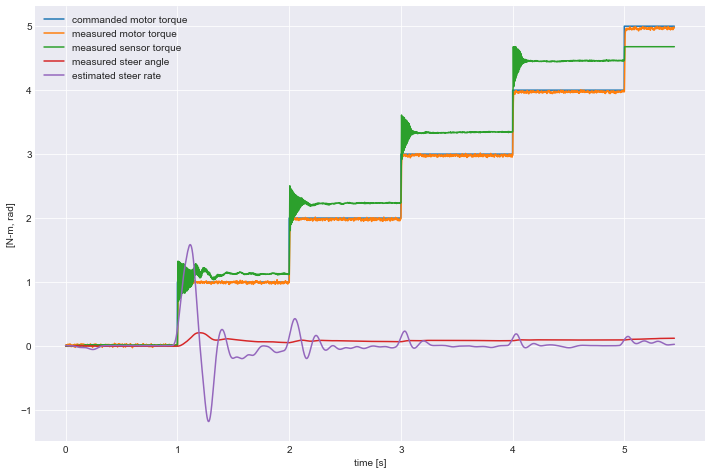

In [7]:
log = ps.ProcessedRecord('logs/positive_constant.pb.cobs')
plt.close('all')
plot_torques(log)
plt.show()

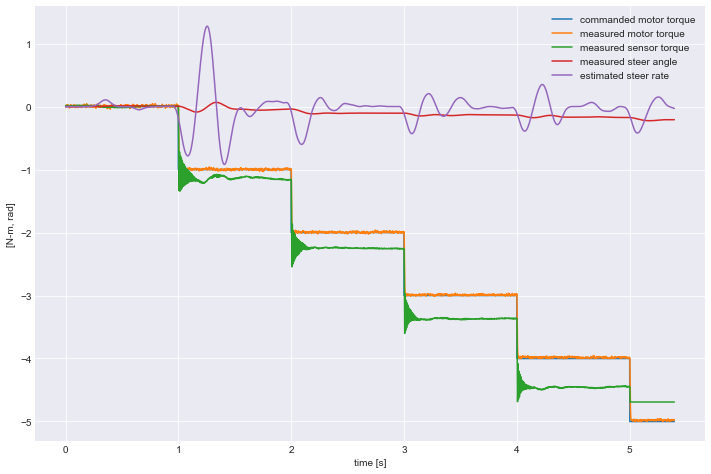

In [8]:
log = ps.ProcessedRecord('logs/negative_constant.pb.cobs')
plt.close('all')
plot_torques(log)
plt.show()